# A BERT for laptops, from scratch

This is a simple BERT lookalike that was developed for training on a laptop (with an Nvidia 3070 RTX GPU). The notebook is developed for educational purposes more than performance, but in a bit more than half a day of training you can get a model that (after further finetuning) obtains ~94% of the performance of the original BERT-base on the GLUE benchmark. The code here builds on work by Geiping & Goldstein [0], Izsak et al [1] and Karpathy [2] who have all made large language models (LLMs) more accessible for modest budgets.

You can execute this notebook from start to end to see the full process of setting up and training a tokenizer, pretraining a BERT model, and finetuning a BERT model on downstream NLP tasks. Most of the code from the notebook can also be found in this repository in regular Python files if you prefer, together with a few extra bits (e.g. [SpanBERT](https://arxiv.org/abs/1907.10529) style sample generation).

The document is split into three sections:
* _Data:_ This is where we obtain and preprocess the data for pretraining, and build and train the BPE tokenizer.
* _Architecture:_ This is where we define our BERT.
* _Training:_ First we pretrain the model on a "masked language modeling" (MLM) objective with a lot of data, then we finetune on a few smaller tasks from the GLUE benchmark.

If you want to run the full notebook on a full size model, expect training the tokenizer to take ~15 hours, pretraining with the MLM objective to take ~17 hours (on a 3070 RTX, adjust expectations for your own system), and finetuning to take about an hour. The notebook was tested with 32GB of regular RAM and 8GB of GPU memory, if you have less you might need to make some changes.

This BERT variant uses:
* BPE (Byte Pair Encoding) tokenization.
* Relative position embeddings.
* Pre-layernorm.
* No dropout.
* Automatic mixed precision.

[0] Geiping, Jonas, and Tom Goldstein. "Cramming: Training a Language Model on a single GPU in one day." _International Conference on Machine Learning_. PMLR, 2023.

[1] Izsak, Peter, Moshe Berchansky, and Omer Levy. "How to train BERT with an academic budget." _arXiv preprint arXiv:2104.07705_ (2021).

[2] Karpathy, Andrej. ["MinGPT"](https://github.com/karpathy/minGPT) (2020).

In [1]:
# Torch, cuda, numpy, scipy, matplotlib, etc are all assumed to be present

# Other dependencies, uncomment this line if you don't have these installed:
# ! pip install datasets tqdm unidecode

import math
import os
import pickle
import random
import re
import string
import time

from collections import Counter
# Use third-party "multiprocess" to fix 
# AttributeError: Can't get attribute 'preprocess_dataset' on <module '__main__' (built-in)>
# from multiprocessing import Pool
from multiprocess import Pool

from matplotlib import pyplot as plt

import numpy as np
import scipy

import torch
import torch.nn as nn
from torch import optim
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.nn import functional as F

from datasets import load_dataset
from tqdm import tqdm
from tqdm.notebook import trange
from unidecode import unidecode

In [2]:
DEVICE = 'mps'

## Data

We will be working with two datasets: [BookCorpusOpen](https://huggingface.co/datasets/bookcorpusopen) and [Wikipedia English](https://huggingface.co/datasets/wikipedia), both of which are available from [Hugging Face](https://huggingface.co/). We are going to do a few things with the data:

1. Fetch the data.
2. Clean the data and collect unique words with their statistics.
3. Generate a byte-pair encoding for the words in the data.
4. Chunk training data to sequences of 128 tokens.
5. Generate samples for training BERT.

### Fetching

Fetch the datasets from Hugging Face. The first time you run this it will download ~26GB of data, plan accordingly. Later calls will use a local cache. The Wikipedia data is split into chunks of roughly similar size to support parallel processing later on.

In [3]:
bc = load_dataset("bookcorpus", split = "train")
wp_a = load_dataset("wikipedia", "20220301.en", split = "train[0:750000]")
wp_b = load_dataset("wikipedia", "20220301.en", split = "train[750000:1500000]")
wp_c = load_dataset("wikipedia", "20220301.en", split = "train[1500000:3250000]")
wp_d = load_dataset("wikipedia", "20220301.en", split = "train[3250000:5000000]")
wp_e = load_dataset("wikipedia", "20220301.en", split = "train[5000000:]")

### Cleaning and collecting word frequency

Define the cleaning logic:

In [4]:
def clean_string(s):
    s = unidecode(s)             # Make sure we have only ASCII characters
    s = s.lower()                # Lowercase
    s = re.sub('[ \t]+', ' ', s) # Replace tabs and sequences of spaces with a single space
    s = s.replace('\n', '\\n')   # Escape newlines
    return s.strip()             # Remove leading and trailing whitespace

Preprocess the data. The code in this section will generate some large files in the `data/` directory.

In [5]:
def preprocess_dataset(d, tag):
    c = Counter() # Will keep track of word counts
    
    # Save clean data to a local text file
    with open(f"data/{tag}.txt", "w") as f:
        for sample in d:
            s_clean = clean_string(sample['text'])
            f.write(s_clean + '\n')
            words = re.findall(r'[a-zA-Z]+', s_clean.replace('\\n', ' ')) # avoid capturing the 'n's of newlines
            c.update(words)
    
    # Pickle counts
    with open(f"data/{tag}_counts.pkl", "wb") as f:
        pickle.dump(c, f)

The function above cleans the input data, stores the clean data, and counts word frequencies in the clean version of the data. These counts will be used to feed the training of the Byte Pair Encoding scheme later on.

We'll process the data in parallel to save quite a bit of time. The below cell might still take half an hour or so to complete.

In [6]:
with Pool(6) as p:
    p.starmap(preprocess_dataset, [(bc, "bookcorpus"),
                                   (wp_a, "wikipedia_a0"),
                                   (wp_b, "wikipedia_0b"),
                                   (wp_c, "wikipedia_c"),
                                   (wp_d, "wikipedia_d"),
                                   (wp_e, "wikipedia_e")])

The above cell generated counts per subset of the data, let's merge this into a single data structure:

In [6]:
word_counts = Counter()
for tag in ["bookcorpus", "wikipedia_a", "wikipedia_b", "wikipedia_c", "wikipedia_d", "wikipedia_e"]:
    with open(f"data/{tag}_counts.pkl", "rb") as f:
        word_counts.update(pickle.load(f))

And then let's have a quick look at common and rare words, as a sanity check:

In [7]:
print("Most common:")
print(sorted(word_counts.items(), key = lambda x: -x[1])[:10])
print("Least common:")
print(sorted(word_counts.items(), key = lambda x: x[1])[:10])

Most common:
[('the', 238227230), ('of', 117781415), ('and', 104334764), ('in', 97520033), ('to', 78612948), ('a', 76470732), ('was', 44506401), ('he', 30383513), ('s', 29998804), ('for', 29685590)]
Least common:
[('mattinglly', 1), ('tennley', 1), ('thatnormally', 1), ('forsince', 1), ('convincingthe', 1), ('darkchocolate', 1), ('towardyour', 1), ('nfidence', 1), ('thepenthouse', 1), ('andunyielding', 1)]


The most common sequences generally seem to make sense. It also makes sense that the least common sequences are mainly misspellings.

### Byte Pair Encoding (BPE)

For a general description of BPE check out [this Hugging Face tutorial](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt). At a high level, BPE is used to shorten the sequences we will feed into the language model in a meaningful way. Training the model on raw characters would be expensive - by using BPE we can represent common words by single unique tokens, and less common words by sequences of a few tokens, where each token hopefully carries some meaning of its own. We will briefly look at what the tokenizer does later on.

We start by defining the alphabet for our data, which is basically all printable ASCII characters and a few special tokens. The `[CLS]` token is fed as the first token of every sequence and may aid fine tuning. The `[MASK]` token is used during pre-training to indicate hidden tokens. The `[SEP]` token can be used to separate sequences in the input (this one becomes important during finetuning). The `[PAD]` token is used to make sure all input sequences consist of a fixed number of tokens.

We also differentiate between characters that are at the beginning of a word and characters that are in the middle. For example the token `"_a"` corresponds to an "a" starting a word, while `"a"` corresponds to an "a" inside the word.

In [8]:
alphabet = (["[CLS]", "[MASK]", "[SEP]", "[PAD]"] +
            [c for c in string.ascii_lowercase] +
            [f"_{c}" for c in string.ascii_lowercase] +
            [symbol for symbol in '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'] +
            ["\\n"])

First we will define a class to take care of encoding sequences. When byte pair encoding a sequence, the alphabet is combined with an ordered set of merge rules which are applied in sequence.

In [9]:
class BPEncoder:
    
    def __init__(self, alphabet, merge_rules, bpe_cache = dict()):
        """
        alphabet: a list of strings
        merge_rules: a list of string pairs to be merged
        """
        self.alphabet = alphabet
        self.merge_rules = merge_rules
        self.bpe_cache = bpe_cache
    
    def total_tokens(self):
        return len(self.alphabet) + len(self.merge_rules)
    
    def all_tokens(self):
        return self.alphabet + [a + b for a, b in self.merge_rules]

    def token_mapping(self):
        tokens = self.all_tokens()
        return {tok: i for i, tok in enumerate(tokens)}
    
    def add_merge_rule(self, merge_rule):
        self.merge_rules.append(merge_rule)
        
    def split_seq(self, s):
        """Split s into units from the alphabet."""
        t = sorted([a for a in alphabet if s.startswith(a)], key = lambda x: -len(x))[0]
        if len(t) < len(s):
            return [t] + self.split_seq(s[len(t):])
        else:
            return [t]
    
    def apply_merge_rule(self, merge_rule, bpe_seq):
        ret = []
        delta_dict = Counter()
        i = 0
        while i < len(bpe_seq) - 1:
            if merge_rule == (bpe_seq[i], bpe_seq[i+1]):
                ret.append(bpe_seq[i] + bpe_seq[i+1])
                
                # This part is a bit hairy and only really necessary for training the encoder (done further down).
                # It's essentially accounting logic to keep track of the occurrence of
                # sequential pairs: when we apply a merge rule, the merged pair disappears
                # everywhere in the sequence, but new pairs also appear. Keeping track of
                # that change this way is a bit more efficient than just re-counting all pairs.
                
                # Example:
                #   We have the sequence [t1, t2, t3, t4] and the merge rule (t2, t3).
                #   The pair (t2, t3) disappears, and pairs (t1, t2+t3) and (t2+t3, t4) appear.
                
                delta_dict.update({merge_rule: -1})
                if i > 0:
                    delta_dict.update({(ret[-2], bpe_seq[i]): -1})
                    delta_dict.update({(ret[-2], bpe_seq[i] + bpe_seq[i+1]): 1})
                if i < len(bpe_seq) - 2:
                    delta_dict.update({(bpe_seq[i+1], bpe_seq[i+2]): -1})
                    delta_dict.update({(bpe_seq[i] + bpe_seq[i+1], bpe_seq[i+2]): 1})
                    
                i += 2
            else:
                ret.append(bpe_seq[i])
                i += 1
        if i == len(bpe_seq) - 1:
            ret.append(bpe_seq[i])
        return ret, delta_dict
        
    def encode(self, s):
        """
        Apply BPE to s.
        This implementation is very slow for encodings with many merge rules.
        In our case that doesn't matter much, we will cache encodings.
        """
        if s in self.bpe_cache:
            return self.bpe_cache[s]
        else:
            ret = self.split_seq(s)
            for mr in self.merge_rules:
                ret, _ = self.apply_merge_rule(mr, ret)
            self.bpe_cache[s] = ret
            return ret

Let's go through an example to get a feel for this:

In [10]:
demo_bpe = BPEncoder(alphabet, [("h", "e"), ("_t", "he"), ("o", "r"), ("f", "or")])

print("Split to alphabet elements:")
print(demo_bpe.split_seq("_therefore"))
print()
print("Apply BPE:")
print(demo_bpe.encode("_therefore"))
print()
tok2idx = demo_bpe.token_mapping()
print("Convert to numeric representation:")
print([tok2idx[tok] for tok in demo_bpe.encode("_therefore")])

Split to alphabet elements:
['_t', 'h', 'e', 'r', 'e', 'f', 'o', 'r', 'e']

Apply BPE:
['_the', 'r', 'e', 'for', 'e']

Convert to numeric representation:
[100, 21, 8, 102, 8]


Now that we have a BPE encoder, we need to learn the encoding from our data. This is what we collected the `word_counts` for earlier. We are only going to generate merge rules for alphabetic sequences: any tokens, numbers or symbols will be kept at the alphabet level.

The algorithm is roughly:
1. Split the sequences for all words into alphabet elements.
2. Count the number of occurrences of all pairs.
3. Add a merge rule for the pair that occurs most often.
4. Apply the merge rule for all words.
5. If we have not reached our desired number of tokens, repeat starting at step 2.

The code has been set up to be a bit more efficient than a naive algorithm (e.g. pair occurrences are not re-calculated every loop, during the loop we keep track of the changes resulting from a new merge rule, see the `apply_merge_rule` method in `BPEncoder`). However, this algorithm could still be sped up significantly. That would add complexity and is beyond the scope of this project.

In [11]:
class BPETrainer:
    
    def __init__(self, word_counts, alphabet):
        self.bpe = BPEncoder(alphabet, [])
        
        self.data = [] # Will hold the encoded version of the words from our data with its count
        self.pair_counts = Counter() # Will hold occurrence frequencies of token pairs
        self.token_word_index = {token: [] for token in self.bpe.all_tokens()} # Maps tokens to the words in which they occur
        if isinstance(word_counts, list):
            for i, pair in enumerate(word_counts):
                word, count = pair
                word_enc = self.bpe.split_seq('_' + word) # Prepend underscore to differentiate leading tokens
                self.data.append((word_enc, count))
                for j in range(0, len(word_enc) - 1):
                    self.pair_counts.update({(word_enc[j], word_enc[j+1]): count})
                for tok in set(word_enc):
                    self.token_word_index[tok].append(i)
        elif isinstance(word_counts, Counter):
            for i, pair in enumerate(word_counts.items()):
                word, count = pair
                word_enc = self.bpe.split_seq('_' + word) # Prepend underscore to differentiate leading tokens
                self.data.append((word_enc, count))
                for j in range(0, len(word_enc) - 1):
                    self.pair_counts.update({(word_enc[j], word_enc[j+1]): count})
                for tok in set(word_enc):
                    self.token_word_index[tok].append(i)
        else:
            raise ValueError('`word_counts` must be a list or a Counter')
            
    
    def add_merge_rule(self, t1, t2):
        """Adds the rule to merge t1 and t2 to the BPE and updates internal statistics."""
        
        # Add the new (merged) token to the word mapping
        self.token_word_index[t1 + t2] = []
            
        # The below code finds words that contain *both* t1 and t2 in a somewhat efficient way.
        # It relies on the fact that the list values in self.token_word_index are in sorted order.
        i = 0
        j = 0
        while i < len(self.token_word_index[t1]) and j < len(self.token_word_index[t2]):

            if self.token_word_index[t1][i] < self.token_word_index[t2][j]:
                i += 1

            elif self.token_word_index[t2][j] < self.token_word_index[t1][i]:
                j += 1

            else:
                # This word contains both t1 and t2: we might need to merge pairs here.
                
                word_idx = self.token_word_index[t1][i]
                word_enc, count = self.data[word_idx]

                # Get the encoded word after applying the merge rule, and the changes
                # that we need to make to our `pair_counts`.
                word_enc_post, delta = self.bpe.apply_merge_rule((t1, t2), word_enc)
                self.data[word_idx] = (word_enc_post, count)
                self.pair_counts.update({pair: d*count for pair, d in delta.items()})
                
                # Update the word index
                if t1 not in word_enc_post:
                    del self.token_word_index[t1][i]
                else:
                    i += 1
                if t2 not in word_enc_post:
                    if t2 != t1:
                        del self.token_word_index[t2][j]
                else:
                    j += 1
                if t1 + t2 in word_enc_post:
                    self.token_word_index[t1 + t2].append(word_idx)

        # Update the BPE to include the new merge rule
        self.bpe.add_merge_rule((t1, t2))
    
    def find_merge_rules(self, token_limit, verbose = False):
        """Add merge rules to the BPE until token_limit is reached."""
        
        while self.bpe.total_tokens() < token_limit:
            
            # Find the most frequent pair.
            # This call could be sped up with a better data structure.
            t1, t2 = max(self.pair_counts, key = self.pair_counts.get)
            count = self.pair_counts.get((t1, t2))
            
            if count == 0:
                print(f"No more tokens to add, every word has its own token already.")
                break
            
            if verbose:
                print(f"{self.bpe.total_tokens()}: {t1} + {t2} -> {t1}{t2} (count = {self.pair_counts.get((t1, t2))})")
            
            # Add the most frequent pair as a merge rule.
            self.add_merge_rule(t1, t2)

For the purpose of this notebook, let's run this process on a random subset of the data only, and up to a relatively small number of merge rules. Running the process on the full `word_counts` dictionary to the full token count (2^15 tokens) takes about 15 hours. We will also print some of the words on which the small tokenizer is trained and show how they are broken up into tokens:

In [53]:
word_counts_small = random.sample([wc for wc in word_counts.items() if wc[1] >= 256], 2**13)

bpet_small = BPETrainer(word_counts_small, alphabet)
bpet_small.find_merge_rules(2**13)

for word, count in word_counts_small[:10]:
    print(f"{word} ({count} occ): {bpet_small.bpe.encode('_' + word)}")

fasciole (615 occ): ['_fasci', 'ole']
yoshihito (444 occ): ['_y', 'oshi', 'h', 'ito']
enablers (420 occ): ['_en', 'ab', 'lers']
lawnmower (1195 occ): ['_lawnmower']
garissa (518 occ): ['_gar', 'issa']
bounding (4250 occ): ['_bounding']
longwy (516 occ): ['_long', 'w', 'y']
subbulakshmi (543 occ): ['_sub', 'b', 'ul', 'ak', 'sh', 'mi']
rackenfauz (797 occ): ['_r', 'ack', 'enf', 'au', 'z']
molo (883 occ): ['_mo', 'lo']


As you can see, common words are likely to be represented by a single token. Less common words are broken into chunks of common sequences, where these sequences often (though definitely not always) have some semantic meaning.

In [54]:
bpet_merg_fn = "data/bert_mr.pkl"
bpet_data_fn = "data/bert_bpet_data.pkl"
if all([os.path.isfile(bpet_merg_fn), os.path.isfile(bpet_data_fn)]):

yes


To run the process on the full training data, up to the full token count, execute this cell:

In [55]:
%%time

bpet_merg_fn = "data/bert_mr.pkl"
bpet_data_fn = "data/bert_bpet_data.pkl"
if not all([os.path.isfile(bpet_merg_fn), os.path.isfile(bpet_data_fn)]):
    # This code generates the data loaded below
    bpet = BPETrainer(word_counts, alphabet)
    bpet.find_merge_rules(2**15, verbose = True)
    
    with open("data/bert_mr.pkl", "wb") as f:
        pickle.dump(bpet.bpe.merge_rules, f)
    
    with open("data/bert_bpet_data.pkl", "wb") as f:
        pickle.dump(bpet.data, f)

CPU times: user 131 µs, sys: 102 µs, total: 233 µs
Wall time: 216 µs


For reruns it's easier to just load saved results from earlier:

In [ ]:
with open("data/bert_mr.pkl", "rb") as f:
    bert_mr = pickle.load(f)

with open("data/bert_bpet_data.pkl", "rb") as f:
    bert_bpet_data = pickle.load(f)

A nice side effect of structuring the training process the way it is in this notebook is that for every single word in our pretraining data, we get the encoded form as part of the BPE training process. That means that rather than re-encoding a word every time we encounter it, we can create a lookup table to find the encoding, which is a lot faster (at least for this poorly optimized encoder):

In [14]:
# Mapping from each word to its encoding
bpe_cache = {''.join(w_enc): w_enc for w_enc, _ in bert_bpet_data}

bert_bpe = BPEncoder(alphabet, bert_mr, bpe_cache)

### Chunking

The cleaned data that we generated earlier did not take into account the fact that we want to train on fixed sample lengths - during pretraining, all our samples will be 128 tokens long. For this purpose we will apply one more preprocessing step, generating a dataset where each line of data has a suitable length, given our trained BPE encoding.

We will need to do this slightly differently between the BookCorpus data and the Wikipedia data - with the BookCorpus data, each sample represents a sentence from a book, and the next sample is the following sentence. For our training process, we will merge such samples to try and fill up the 128 token frames. The Wikipedia data on the other hand has one sample per article, and we want to avoid combining unrelated sentences on different topics. For the Wikipedia data, once we reach the end of an article, we will fill the rest of the current training sample with `[PAD]` tokens.

In [15]:
def atomize(s):
    """Break down a sample into symbols and words."""
    atom_re = r'(\[(CLS|SEP|PAD|MASK)\]|[a-z]+|\\n|[0-9]|\\|[!#$%&\'()*+,-./:;<=>?@[\]^_`{|}~])'
    return [m[0] for m in re.findall(atom_re, s)]
    
def chunks(fname, bpe, max_length, merge_lines = False):
    ret_list = []
    ret_tok_len = 0
        
    with open(fname, "r") as f:
        for line in f:
            atoms = atomize(line)
            for atom in atoms:
                if atom.isalpha():
                    # Deal with some weird sequences in the training data
                    if len(bpe.encode('_' + atom)) > max_length:
                        continue
                    if ret_tok_len + len(bpe.encode('_' + atom)) > max_length:
                        yield ' '.join(ret_list)
                        ret_list = []
                        ret_tok_len = 0
                    ret_list.append(atom)
                    ret_tok_len += len(bpe.encode('_' + atom))
                else:
                    if ret_tok_len == max_length:
                        yield ' '.join(ret_list)
                        ret_list = []
                        ret_tok_len = 0
                    ret_list.append(atom)
                    ret_tok_len += 1
            if not merge_lines:
                yield ' '.join(ret_list)
                ret_list = []
                ret_tok_len = 0
    yield ' '.join(ret_list)

Let's see what a sample looks like. We will take `max_length` to be 126, because during training we will still prepend a `[CLS]` token and append a `[SEP]` token.

In [16]:
test_chunk = chunks("data/wikipedia_d.txt", bert_bpe, 126, merge_lines = True)
print(next(test_chunk))

the camelen iv 4 4 0 is a four wheel drive modular mission system vehicle designed by jez hermer mbe , ceo of ovik special vehicles . designed and developed in 2 0 1 0 , it is based upon the iveco daily 4 x 4 chassis but incorporates a number of modifications designed by ovik plus a range of specialist mission modules which can be interchanged rapidly , giving the vehicle a multi - functional utility . \n \n concept of use \n the general concept behind the cameleom system is to provide military forces , civil and emergency services and commercial users with a modular vehicle which can be reconfigured , rapidly , into


The below code generates a chunked version of all the training data - again we will parallellize the process, it will take up quite a bit of disk space and take approximately half an hour.

In [17]:
def chunk_samples(fname, merge_lines):
    cs = chunks("data/" + fname, bert_bpe, 126, merge_lines)
    with open(f"data/chunked_{fname}", "w") as f:
        for c in cs:
            f.write(c + '\n')

with Pool(6) as p:
    p.starmap(chunk_samples, [("bookcorpus.txt", True),
                              ("wikipedia_a.txt", False),
                              ("wikipedia_b.txt", False),
                              ("wikipedia_c.txt", False),
                              ("wikipedia_d.txt", False),
                              ("wikipedia_e.txt", False)])

We will now merge all the data into one file and shuffle it. First we shuffle the individual files, then we randomly merge the resulting files. The reason for the roundabout procedure is that the combined file is too large to fit in memory (at least on my machine). The reason that we apply weights during file merge is that we don't want shorter files to be over-represented in earlier parts of the training data - the files we generated vary a bit in size, and also in content, so that could potentially cause problems.

In [18]:
tags = ["bookcorpus", "wikipedia_a", "wikipedia_b", "wikipedia_c", "wikipedia_d", "wikipedia_e"]

In [19]:
for tag in tags:
    lines = open(f"data/chunked_{tag}.txt", "r").readlines()
    random.shuffle(lines)
    open(f"data/shuffled_chunked_{tag}.txt", "w").writelines(lines)

In [20]:
read_handles = [open(f"data/shuffled_chunked_{tag}.txt", "r") for tag in tags]
sizes = [os.stat(f"data/shuffled_chunked_{tag}.txt").st_size for tag in tags]
names = [t for t in tags]

with open("data/pretrain.txt", "w") as f:
    while len(read_handles) > 0:
        i = random.choices(range(len(read_handles)), weights = sizes)[0]
        try:
            line = next(read_handles[i])
            if line != '\n': # A few cases of empty lines show up
                f.write(line)
        except StopIteration:
            read_handles[i].close()
            print(f"Done with {names[i]}")
            del read_handles[i], sizes[i], names[i]

Done with wikipedia_a
Done with bookcorpus
Done with wikipedia_b
Done with wikipedia_c
Done with wikipedia_d
Done with wikipedia_e


### Generating training samples

We now have input data of the right size in a workable format. The next step is to generate the actual training samples for pre-training BERT. Different approaches have been used for this by different people, we will go with a relatively simple approach here. We are going to train a BERT on 128 tokens at a time, and during pre-training we will mask 15% of the input tokens and score the model on how well it manages to predict what the missing tokens are.

To give some intuition for what we are trying to do, an input sample might look something like

`['i', 'went', 'to', 'the', '[MASK]', 'for', 'lunch']`

for which the model would need to predict

`[ - ,     - ,   - ,    - , 'cafeteria', - ,      - ]`

The common case will be to leave out a token and replace it with `[MASK]` (80% of the time). However, in 10% of cases instead of `[MASK]` we will use a random token, and in 10% of cases we won't perform a replacement. This is similar to how training was done in the original BERT paper.

In [21]:
def encode_sample(sample, bpe):
    encoded = []
    for item in sample.strip().split(' '):
        if item.isalpha():
            encoded += [tok for tok in bpe.encode('_' + item)]
        else:
            encoded.append(item)
    return encoded

def samples_and_masks(fname, length, bpe):
    """Assumes that all samples in fname have been sized not to exceed `length`."""
    tok2idx = bpe.token_mapping()
    
    with open(fname, "r") as f:
        for sample in f:
            
            # Apply BPE to the sample
            encoded = [tok2idx[e] for e in encode_sample(sample, bpe)]
            total_tokens = len(encoded)
            
            # Generate mask in the shape of the sample
            mask_count = math.ceil(0.15 * total_tokens)
            mask = [1] * mask_count + [0] * (total_tokens - mask_count)
            random.shuffle(mask)
            
            # Generate ground truth and mask in matching shape
            training_output = [tok2idx["[CLS]"]] + encoded + [tok2idx["[SEP]"]] + [tok2idx["[PAD]"]] * (length - total_tokens - 2)
            training_mask = [0] + mask + [0] + [0] * (length - total_tokens - 2)
            
            # Generate input data
            training_input = [t for t in training_output]
            for i in range(length):
                if training_mask[i] == 1: # Mask this token
                    r = random.random()
                    if r < 0.8:   # Regular masking
                        training_input[i] = tok2idx["[MASK]"]
                    elif r < 0.9: # Random other token instead of [MASK]
                        training_input[i] = random.randrange(bpe.total_tokens())
                    else:         # Feed the original token as input, untouched
                        pass
            
            yield [training_input, training_output, training_mask]

This time we will not write training samples to disk - we will generate them on the fly during training. This makes it easier to apply different transformation (e.g. a SpanBERT objective) or to re-randomize for subsequent epochs.

## Architecture

We are now at a point where we can define the BERT model. We will pretty closely follow the architecture described in the [Cramming paper](https://arxiv.org/abs/2212.14034). A lot of the structure of the below code is borrowed from Andrej Karpathy's [minGPT](https://github.com/karpathy/minGPT).

The main differences from the original BERT implementation are the following:
* Pre-LayerNorm (marked in the code below).
* No dropout.
* No biases in transformer attention, in transformer MLPs, or in the decoder of the model.
* An additional LayerNorm right after the embedding layer.

The main difference from the Cramming paper is that the architecture here uses relative position embeddings as introduced by [Shaw et al](https://arxiv.org/abs/1803.02155). The implementation here only adds position representations to keys, not to values. Compared to the original absolute position embeddings, this approach slows down training by ~4% but it makes up for it in improved model performance.

This is not the time and place to explain transformers in detail. For that, if you have a lot of time, go through [Stanford's CS 224N](https://web.stanford.edu/class/cs224n/). If you don't have a lot of time, Andrej Karpathy gives [a good high-level overview](https://www.youtube.com/watch?v=kCc8FmEb1nY).

The first two components define the transformer block:

In [22]:
class SelfAttention(nn.Module):
    """
    Bi-directional transformer self-attention.
    Uses relative position embeddings, shared across tokens and attention heads, but unique for each layer.
    """

    def __init__(self, config):
        super().__init__()
        
        self.config = config
        embed_size = config["embed_size"]
        n_head = config["n_head"]
        assert embed_size % n_head == 0
        
        # This is clipping distance (k) in Shaw et al
        pos_emb_radius = config["pos_emb_radius"]
        pos_emb_units = config["embed_size"] // config["n_head"]
        
        # Position embedding vectors for use on keys
        # This is w^K in Shaw et al
        self.pos_emb_k = nn.Parameter(torch.zeros(2 * pos_emb_radius, pos_emb_units))
        torch.nn.init.normal_(self.pos_emb_k, mean=0.0, std=0.02)
        
        # key, query, value projections for all heads
        self.key = nn.Linear(embed_size, embed_size, bias = False)
        self.query = nn.Linear(embed_size, embed_size, bias = False)
        self.value = nn.Linear(embed_size, embed_size, bias = False)
        
        # output projection
        self.proj = nn.Linear(embed_size, embed_size, bias = False)

    def forward(self, x):
        batch_size, context_size, embed_size = x.size()
        assert embed_size == self.config["embed_size"]
        
        n_head = self.config["n_head"]
        head_size = embed_size // n_head
        
        pos_emb_size, head_size = self.pos_emb_k.size()
        pos_emb_radius = self.config["pos_emb_radius"]
        assert pos_emb_size == 2 * pos_emb_radius

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(batch_size, context_size, n_head, head_size).transpose(1, 2) # (batch_size, n_head, context_size, head_size)
        q = self.query(x).view(batch_size, context_size, n_head, head_size).transpose(1, 2) # (batch_size, n_head, context_size, head_size)
        v = self.value(x).view(batch_size, context_size, n_head, head_size).transpose(1, 2) # (batch_size, n_head, context_size, head_size)
        
        # Below section implements x_i W^Q (a_{ij}^K)^T from Shaw et al
        # position attention: (batch_size, n_head, context_size, head_size) x (1, 1, pos_emb_size, head_size) -> (batch_size, n_head, context_size, pos_emb_size)
        att_rel_pos = q @ self.pos_emb_k.view(1, 1, pos_emb_size, head_size).transpose(-2, -1)
        att_idxs = (torch.clamp(torch.arange(context_size)[None, :] - torch.arange(context_size)[:, None], -pos_emb_radius, pos_emb_radius-1) % pos_emb_size).to(DEVICE)
        att_pos = torch.gather(att_rel_pos, 3, att_idxs.expand((batch_size, n_head, context_size, context_size)))
        assert att_pos.shape == (batch_size, n_head, context_size, context_size)
        
        # value attention: (batch_size, n_head, context_size, head_size) x (batch_size, n_head, context_size, head_size) -> (batch_size, n_head, context_size, context_size)
        att_val = q @ k.transpose(-2, -1)
        
        # combined attention
        att_scale = 1.0 / math.sqrt(k.size(-1))
        att = F.softmax((att_val + att_pos) * att_scale, dim=-1) # Equation (5) from Shaw et al
        
        y = att @ v # (batch_size, n_head, context_size, context_size) x (batch_size, n_head, context_size, head_size) -> (batch_size, n_head, context_size, head_size)
        y = y.transpose(1, 2).contiguous().view(batch_size, context_size, embed_size) # re-assemble all head outputs side by side

        # output projection
        y = self.proj(y)
        return y

The relative position embeddings make the attention code a bit more complex than it could be, e.g. MinGPT has simpler attent logic. It also slows down training by about 4%. It seems to make up for this in improved training, however, and provides a lot of flexibility for training on larger samples (more than 128 tokens) after pretraining. With absolute position embeddings it's not straightforward to change the context size.

In [23]:
class Block(nn.Module):
    """Pre-LayerNorm transformer block."""

    def __init__(self, config):
        super().__init__()
        
        embed_size = config["embed_size"]
        
        self.norm1 = nn.LayerNorm(embed_size, eps = 1e-6)
        self.attn = SelfAttention(config)
        
        self.norm2 = nn.LayerNorm(embed_size, eps = 1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size, bias = False),
            nn.GELU(),
            nn.Linear(4 * embed_size, embed_size, bias = False),
        )

    def forward(self, x):
        # This is Pre-LayerNorm
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        
        # Post-LayerNorm would look more like
        # x = self.norm1(x + self.attn)
        # x = self.norm2(x + self.mlp)
        
        return x

We then build BERT out of an embedding layer and a sequence of transformer blocks, with some carefully placed layernorms.

In [24]:
class BERT(nn.Module):
    """Headless BERT."""

    def __init__(self, config):
        super().__init__()
        
        self.config = config
        vocab_size = config["vocab_size"]
        embed_size = config["embed_size"]
        n_layer = config["n_layer"]

        # token embedding
        self.tok_emb = nn.Embedding(vocab_size, embed_size)
        self.norm_emb = nn.LayerNorm(embed_size, eps = 1e-6)
        
        # transformer
        self.transformer = nn.Sequential(*[Block(config) for _ in range(n_layer)])
        
        # final layernorm
        self.norm_final = nn.LayerNorm(embed_size, eps = 1e-6)

        print("number of parameters: {}".format(sum(p.numel() for p in self.parameters())))
        
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        batch_size, context_size = x.size()
    
        x = self.tok_emb(x)
        x = self.norm_emb(x)
        x = self.transformer(x)
        x = self.norm_final(x)
        
        return x

We have BERT, but we can't do anything with it yet: the top layer generates only hidden unit activations/embeddings. Depending on the training scenario, we will put a different "head" on BERT. During pre-training, BERT is learning masked language modeling (MLM), and it will take an MLM head that makes a token prediction for every position in the input. For our fine-tuning, BERT learns a single output for each input sentence (e.g. a true/false classification or some score), and we will use two different heads, one for classification and one for regression. These heads ignore most of the activations at BERT's top, and use only the activations for the very first token as input features during training.

In [25]:
class MLMHead(nn.Module):
    """
    BERT head for masked language modeling.
    Note that this does *not* implement sparse prediction as mentioned in the Cramming paper. Predictions are calculated for all tokens.
    """
    
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        vocab_size = config["vocab_size"]
        embed_size = config["embed_size"]
        
        self.tok_unemb = nn.Linear(embed_size, vocab_size, bias = False)
    
    def forward(self, x, y):
        logits = self.tok_unemb(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index = 0)
        return logits, loss

In [26]:
class CLSHead(nn.Module):
    """
    BERT head for classification.
    A prediction is only calculated for the first ([CLS]) token.
    """
    
    def __init__(self, config, n_classes):
        super().__init__()
        
        self.config = config
        embed_size = config["embed_size"]
        
        self.classifier = nn.Linear(embed_size, n_classes)
    
    def forward(self, x, y = None):
        logits = self.classifier(x[:, 0, :])
        loss = None
        if y is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        return logits, loss

In [27]:
class RegHead(nn.Module):
    """
    BERT head for regression.
    A prediction is only calculated for the first ([CLS]) token.
    """
    
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        embed_size = config["embed_size"]
        
        self.regressor = nn.Linear(embed_size, 1)
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x, y = None):
        y_hat = self.regressor(x[:, 0, :])
        loss = None
        if y is not None:
            loss = self.loss_fn(y_hat.view(-1), y.view(-1))
        return y_hat, loss

## Training

We have our data and we have our model. Time to set up training loops.

We will train in two phases:
1. Unsupervised pre-training on the data we're generating with the `samples_and_masks` function we defined earlier.
2. Supervised fine-tuning on specific tasks where we take a model from (1) and specialize it further.

### Pre-training

Configure the model:

In [28]:
# BERT base, but with relative position embeddings
config = {"vocab_size": 2**15, "embed_size": 768, "context_size": 128, "n_layer": 12, "n_head": 12, "pos_emb_radius": 16}
device = "mps"
bert = BERT(config).to(DEVICE)
mlm_head = MLMHead(config).to(DEVICE)

number of parameters: 110164992


Configure the different levels of batching. In this notebook, a minibatch is a set of training samples for which gradients are calculated simultaneously (they are processed by the GPU at the same time). A (regular) batch is a set of training samples for which gradients are accumulated before a training step is taken, batch sizes changed throughout training and are defined in the `get_batch_size` function below. A macrobatch is a set of training samples that gets transferred to the GPU simultaneously. It is the granularity at which learning rate and batch size are varied, and the full duration of the training procedure is expressed in number of macrobatches (`macrobatch_count`). On a 3070 RTX GPU one macrobatch takes a bit over 4 minutes to process.

In [29]:
minibatch_size = 2**5   # Number of samples on which we compute gradients simultaneously
macrobatch_size = 2**15 # Number of samples we transfer to the GPU at the same time
macrobatch_count = 2**8 # Total number of macrobatches we transfer in the whole training process

The below function yields the training data as Torch tensors, one macrobatch at a time. It returns two values, the first being inputs (the "x" data), the second being training targets (the "y" data).

In [30]:
def macrobatches(macrobatch_size):
    """Convert `samples_and_masks` to Torch matrices of size macrobatch_size * 128."""
    ss = samples_and_masks("data/pretrain.txt", 128, bert_bpe)
    training_data = []
    for s in ss:
        training_data.append(s)
        if len(training_data) == macrobatch_size:
            training_data = np.array(training_data, dtype = 'int16')
            yield training_data[:, 0, :], training_data[:, 1, :] * training_data[:, 2, :]
            training_data = []

We vary the learning rate throughout training. The learning rate is first gradually increased ("warmup") and at the end is gradually decreased ("annealed").

In [31]:
def get_lr(macrobatch, max_lr = 1e-3):
    """
    One-cycle LR schedule, scaled by fraction of training time remaining, as described in Cramming.
    See plot below.
    """
    c = macrobatch + 0.5 # Midpoint of chunk
    lr = max_lr
    if c / macrobatch_count < 0.5:
        lr = lr * 2 * c / macrobatch_count
    else:
        lr = lr * 2 * (macrobatch_count - c) / macrobatch_count
    lr = lr * (macrobatch_count - c) / macrobatch_count
    return lr

Here is a visualization of how learning rate changes throughout pretraining:

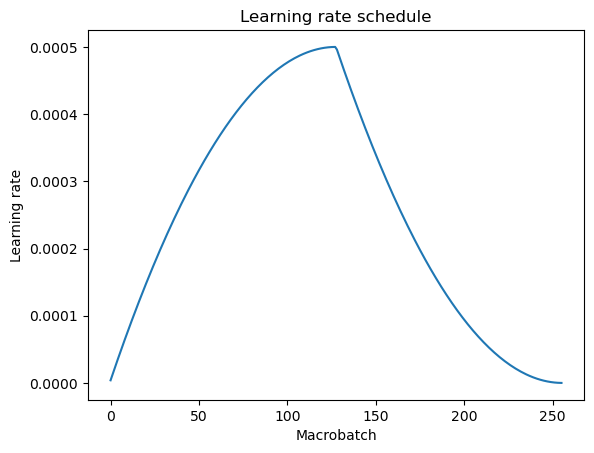

In [32]:
plt.plot(range(macrobatch_count), [get_lr(m) for m in range(macrobatch_count)])
plt.title("Learning rate schedule")
plt.xlabel("Macrobatch")
plt.ylabel("Learning rate")
plt.show()

Batch size is also varied throughout pretraining - in the beginning our network is still poorly fit and our priority is to make rapid progress, so we use small batch sizes (noisy gradients). As the network gets better, it becomes more important to take our optimization steps carefully, so we gradually increase batch sizes (for more precise gradients).

In [33]:
def get_batch_size(macrobatch):
    """Gradually increasing batch size through the training process based on description in Cramming."""
    if macrobatch >= 2**7:
        return 2**11
    elif macrobatch >= 2**6:
        return 2**10
    elif macrobatch >= 2**5:
        return 2**9
    elif macrobatch >= 2**4:
        return 2**8
    elif macrobatch >= 2**3:
        return 2**7
    elif macrobatch >= 2**2:
        return 2**6
    else:
        return 2**5 # == 32, is minibatch_size, which we don't want to go below

Again, a visualization might help:

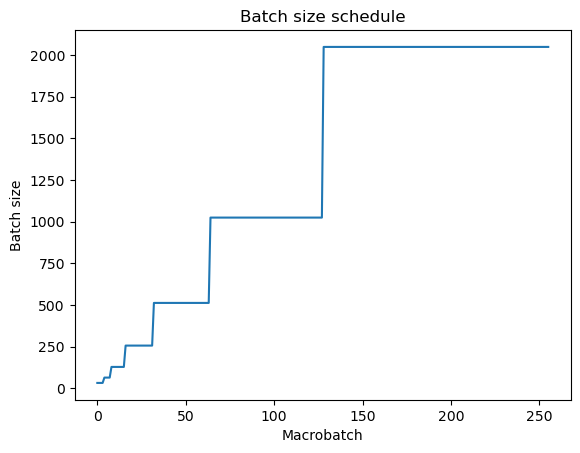

In [34]:
plt.plot(range(macrobatch_count), [get_batch_size(m) for m in range(macrobatch_count)])
plt.title("Batch size schedule")
plt.xlabel("Macrobatch")
plt.ylabel("Batch size")
plt.show()

The optimizer is configured so that regularization is only applied to weights, not biases:

In [36]:
param_groups = [{'params': [p for p in list(bert.parameters()) + list(mlm_head.parameters()) if p.dim() >= 2], 'weight_decay': 0.01},
                {'params': [p for p in list(bert.parameters()) + list(mlm_head.parameters()) if p.dim() < 2], 'weight_decay': 0}]
optimizer = optim.AdamW(param_groups, lr = get_lr(0), betas = (0.9, 0.98), eps = 1e-12)  # fused = True
scaler = GradScaler() # This is for automatic mixed precision

/Users/skylar/homebrew/Caskroom/mambaforge/base/envs/bert/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


And finally we get to the training loop. A small amount of complexity is introduced by the use of automatic mixed precision, but this is worthwhile as it speeds up training approximately two-fold (!). Note that the code below will run for 2 iterations only, to do a full training run comment out/remove the indicated lines. Later on in the notebook there will be a sleight of hand where we actually load weights fitted during a full run.

In [52]:
%%time

PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
cumulative_samples = 0
mbs = macrobatches(macrobatch_size)

f_log = "BERT.csv"

with open(f_log, "w") as f:
    f.write("macrobatch,cumulative_samples,duration,loss,lr")

for macrobatch in tqdm(range(macrobatch_count)):
    
    # REMOVE THE BELOW TWO LINES IF YOU WANT TO DO A FULL TRAINING RUN
    if macrobatch == 2:
        break
    
    # Set chunk training parameters
    batch_size = get_batch_size(macrobatch)
    lr = get_lr(macrobatch)
    for g in optimizer.param_groups:
        g['lr'] = get_lr(macrobatch)
    
    # Load a new macrobatch
    xs, ys = next(mbs)
    torch_xs = torch.LongTensor(xs).to(DEVICE)
    torch_ys = torch.LongTensor(ys).to(DEVICE)
    
    # Iterate over the batches in the macrobatch
    for i in range(0, xs.shape[0] // batch_size):
        batch_start_time = time.time()
        
        batch_loss = 0
        
        batch_start_idx = i * batch_size
        batch_data_torch_xs = torch_xs[batch_start_idx:batch_start_idx+batch_size, :]
        batch_data_torch_ys = torch_ys[batch_start_idx:batch_start_idx+batch_size, :]

        optimizer.zero_grad(set_to_none = True)
        
        # Iterate over the minibatches in the batch
        for j in range(0, batch_size // minibatch_size):
            mb_start_idx = minibatch_size * j
            mb_end_idx = mb_start_idx + minibatch_size

            # Use automatic mixed precision for (much) better performance
            with autocast(device_type='cpu', dtype=torch.bfloat16):
                _, loss = mlm_head(bert(batch_data_torch_xs[mb_start_idx:mb_end_idx]), batch_data_torch_ys[mb_start_idx:mb_end_idx])

            # Correct for the fact that we are minibatching
            corrected_loss = loss / (batch_size // minibatch_size)
            batch_loss += corrected_loss

            # Need to use scaler.scale for automatic mixed precision
            scaler.scale(corrected_loss).backward()
            
            cumulative_samples += minibatch_size

        # If we don't scaler.unscale_ here, gradient clipping will fail spectacularly, because it will act on arbitrarily scaled gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(bert.parameters(), 0.5)
        scaler.step(optimizer)
        scaler.update()
        
        batch_duration = time.time() - batch_start_time
        
        with open(f_log, "a") as f:
            f.write(f"{macrobatch:03d},{cumulative_samples:09d},{batch_duration:05.3f},{batch_loss.item():05.2f},{lr:0.6f}")
            
    torch.save(bert.state_dict(), f"BERT.weights")
    torch.save(mlm_head.state_dict(), f"MLMHead.weights")

  0%|                                                                                                                                                                                                                                                   | 0/256 [00:05<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 3.82 GB, other allocations: 2.95 GB, max allowed: 6.77 GB). Tried to allocate 6.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

### Fine-tuning

We have a pre-trained BERT! That's great, but now let's do something real with it (because who cares about guessing tokens that we hid on purpose?).

We will now train on two tasks from the GLUE benchmark. There are more tasks in the benchmark (BERT was evaluated on 6 other tasks as well) and you can find code for those in this repository, but for this notebook we will keep it simple.

The first task we will use is STS-B, the Semantic Textual Similary Benchmark. In this task, the model gets two input sentences, and has to predict how similar they are in meaning on a scale of 1 to 5. An example from the data set is: (sentence 1) "People are playing cricket.", (sentence 2) "Men are playing cricket.", which has a similarity score of 3.2 in the data, indicating that the sentences are fairly similar, but not perfectly so (people could include women, after all). This is the only regression task in the GLUE benchmark on which BERT is evaluated, all other tasks are classification tasks.

The second task is SST-2, the Stanford Sentiment Treebank. This task takes only a single sentence as input, and the requirement is to determine whether the sentence has a positive (1) or negative (0) sentiment. A positive example from the dataset is "a gorgeous , witty , seductive movie . ", while a negative example is "unflinchingly bleak and desperate ".

Because we are using different datasets than during pretraining, we need to redo some of the logic for cleaning input sentences:

In [ ]:
def encode_sentence(sentence, bpe):
    """Take a string sentence and turn it into a list of BPE tokens."""
    encoded = []
    for atom in atomize(clean_string(sentence)):
        if atom.isalpha():
            encoded += [tok for tok in bpe.encode('_' + atom)]
        else:
            encoded.append(atom)
    return encoded

For a number of downstream tasks (including STS-B), the structure of the input data is also different because now we have _2_ sentences as input. This is where the `[SEP]` token that we introduced earlier comes in. Training data is fed in in the form `['[CLS]'] + sentence1 + ['[SEP]'] + sentence2 + ['[PAD]'] * x` where the number of `[PAD]` tokens at the end is chosen such that the total number of tokens has the right length.

Some downstream tasks also include data that requires more than 128 tokens to represent. This is where we can benefit from the fact that our BERT uses relative position embeddings rather than absolute: we can use the model on longer samples by need.

In [ ]:
def prep_data(left_sentences, right_sentences, targets, bpe, length = 128, classification_target = True):
    """
    Take two lists of string sentences and a list of targets and generate Torch matrices for training.
    If the targets are not categorical (i.e. we're doing regression), set classification_target = False.
    """
    assert len(left_sentences) == len(right_sentences) == len(targets)
    num_samples = len(left_sentences)
    tok2idx = bpe.token_mapping()
    xs = []
    ys = []
    skipped = 0
    for i in range(num_samples):
        left_encoded = encode_sentence(left_sentences[i], bpe)
        right_encoded = encode_sentence(right_sentences[i], bpe)
        x = ([tok2idx["[CLS]"]] + 
             [tok2idx[e] for e in left_encoded] +
             [tok2idx["[SEP]"]] +
             [tok2idx[e] for e in right_encoded] +
             [tok2idx["[PAD]"]] * (length - len(left_encoded) - len(right_encoded) - 2))
        if len(x) == length:
            xs.append(x)
            ys.append(targets[i])
        else:
            print(f"WARNING: Skipping sample of length {len(x)} at index {i}")
            skipped += 1
    print(f"Skipped {skipped} samples ({skipped/num_samples * 100}%)")
    joint = list(zip(xs, ys))
    random.shuffle(joint)
    xs, ys = zip(*joint)
    xs = torch.LongTensor(xs).to(DEVICE)
    if classification_target:
        ys = torch.LongTensor(ys).to(DEVICE)
    else:
        ys = torch.tensor(ys, device = DEVICE)
    return xs, ys

This helper function implements the training loop for fine tuning. The datasets for the GLUE benchmark all fit in GPU memory entirely, so there is no need for "macrobatching" logic here. The implementation also uses a much simpler learning rate schedule, and a constant batch size. The current settings are likely suboptimal, and are probably one of the first places to look if you want to get a higher GLUE score out of this model (and you don't just want to train for longer).

In [ ]:
def finetune(bert, head, xs, ys):
    """
    Fairly simple training procedure going through xs and ys for 5 epochs.
    Batch size is constant, learning rate is warmed up and decayed but is constant per epoch.
    `bert` and `head` are modified in-place (you might not want to do this at home), this function does not return anything.
    """
    batch_size = 16
    total_samples = xs.shape[0]
    
    param_groups = [{'params': [p for p in list(bert.parameters()) + list(head.parameters()) if p.dim() >= 2], 'weight_decay': 0.01},
                    {'params': [p for p in list(bert.parameters()) + list(head.parameters()) if p.dim() < 2], 'weight_decay': 0}]
    optimizer = optim.AdamW(param_groups, lr = 4e-5, betas = (0.9, 0.98), eps = 1e-12, fused = True)
    scaler = GradScaler()
    
    # Poor man's warmup and decay
    lrs = [1e-5, 4e-5, 4e-5, 2e-5, 1e-5]
    
    for epoch in tqdm(range(5)):
        
        for g in optimizer.param_groups:
            g['lr'] = lrs[epoch]
                        
        i = 0
        while i < total_samples:

            batch_xs = xs[i:min(i+batch_size, total_samples), :]
            batch_ys = ys[i:min(i+batch_size, total_samples)]

            optimizer.zero_grad(set_to_none = True)

            with autocast(device_type=DEVICE, dtype=torch.float16):
                _, loss = head(bert(batch_xs), batch_ys)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            i += batch_size

Once we have a finetuned trained model, we need to evaluate its performance on test data (we will use the validation datasets for that, we haven't used them for any other purpose so that can give a safe performance estimate).

In [ ]:
def cls_predict(bert, cls_head, xs):
    """Take a trained BERT and CLSHead and generate predictions for the inputs xs."""
    pred = []
    for i in tqdm(range(xs.shape[0])):
        with torch.no_grad():
            logits, _ = cls_head(bert(xs[i:i+1]))
        pred.append(torch.argmax(logits))
    return torch.LongTensor(pred).to(DEVICE)

In [ ]:
def reg_predict(bert, reg_head, xs):
    """Take a trained BERT and RegHead and generate predictions for the inputs xs."""
    pred = []
    for i in tqdm(range(xs.shape[0])):
        with torch.no_grad():
            y_hat, _ = reg_head(bert(xs[i:i+1]))
        pred.append(y_hat)
    return torch.tensor(pred, device = DEVICE)

And once we have predictions for our validation data, we need a way to quantify how good those predictions are. STS-B uses Spearman correlation in the GLUE benchmark, and SST-2 uses plain old accuracy.

In [ ]:
def accuracy(pred, true):
    """Calculate accuracy from predictions and ground truth."""
    return (torch.sum(pred == true) / pred.shape[0]).item()

In [ ]:
def spearman(pred, true):
    """Return Spearman correlation for predictions and ground truth."""
    return scipy.stats.spearmanr(np.array(pred.cpu()), np.array(true.cpu())).correlation

We now have all the components we need to evaluate the performance of our pretrained model after finetuning:

In [ ]:
def eval_stsb(bert, bpe, length = 192):
    """Take a pre-trained BERT, finetune on STS-B, and return performance."""
    reg_head_stsb = RegHead(config).to(DEVICE)
    
    stsb_train = load_dataset("glue", "stsb", split = "train")
    stsb_train_xs, stsb_train_ys = prep_data([s['sentence1'] for s in stsb_train],
                                             [s['sentence2'] for s in stsb_train],
                                             [s['label'] for s in stsb_train],
                                             bpe,
                                             length = length,
                                             classification_target = False)

    finetune(bert, reg_head_stsb, stsb_train_xs, stsb_train_ys)

    stsb_val = load_dataset("glue", "stsb", split = "validation")
    stsb_val_xs, stsb_val_ys = prep_data([s['sentence1'] for s in stsb_val],
                                         [s['sentence2'] for s in stsb_val],
                                         [s['label'] for s in stsb_val],
                                         bpe,
                                         length = length,
                                         classification_target = False)

    return spearman(reg_predict(bert, reg_head_stsb, stsb_val_xs), stsb_val_ys)

In [ ]:
def eval_sst2(bert, bpe):
    """Take a pre-trained BERT, finetune on SST2, and return performance."""
    cls_head_sst2 = CLSHead(config, 2).to(DEVICE)
    
    sst2_train = load_dataset("glue", "sst2", split = "train")
    sst2_train_xs, sst2_train_ys = prep_data([s['sentence'] for s in sst2_train],
                                             ['' for s in sst2_train],
                                             [s['label'] for s in sst2_train],
                                             bpe)

    finetune(bert, cls_head_sst2, sst2_train_xs, sst2_train_ys)

    sst2_val = load_dataset("glue", "sst2", split = "validation")
    sst2_val_xs, sst2_val_ys = prep_data([s['sentence'] for s in sst2_val],
                                         ['' for s in sst2_val],
                                         [s['label'] for s in sst2_val],
                                         bpe)

    return accuracy(cls_predict(bert, cls_head_sst2, sst2_val_xs), sst2_val_ys)

In [ ]:
results = []
bert = BERT(config).to(DEVICE)

ws = "BERT.weights"

print(f"{ws} -> Starting STS-B...")
bert.load_state_dict(torch.load(ws), strict = False)
stsb_score = eval_stsb(bert, bert_bpe)
print(f"{ws} -> STS-B score: {stsb_score}")

print(f"{ws} -> Starting SST-2...")
bert.load_state_dict(torch.load(ws), strict = False)
sst2_score = eval_sst2(bert, bert_bpe)
print(f"{ws} -> SST-2 score: {sst2_score}")

The convention with GLUE is to scale these scores by 100, so we scored 83.5 on STS-B and 88.4 on SST-2. For reference, the original BERT-base scored 85.8 on STS-B and 93.5 on SST-2. Not bad! (Note though that BERT was evaluated on a held out test set, and in our case we're evaluating on the validation set, so some caution is required).

### Tinker time

That's it - you've now seen the whole process of training and evaluating a BERT lookalike. The training process is sufficiently fast that you can do some interesting experimentation even just on a laptop. Here are some results from variants that I've tried:

|                                                      | Tokens seen | MLM loss | MNLI m | MNLI mm | QQP  | QNLI | SST-2 | CoLA | CoLA run 2 | STS-B | MRPC | RTE  | RTE run 2 | Average |
| ---------------------------------------------------- | ----------- | -------- | ------ | ------- | ---- | ---- | ----- | ---- | ---------- | ----- | ---- | ---- | --------- | ------- |
| % samples longer than 128 tokens                     |             |          | 0.32   | 0.34    | 0.02 | 0.55 | 0     | 0    | 0          | 0     | 0    | 12.6 | 12.6      |         |
| ---------------------------------------------------- | ----------- | -------- | ------ | ------- | ---- | ---- | ----- | ---- | ---------- | ----- | ---- | ---- | --------- | ------- |
| Absolute position embeddings                         | 2^30        | 2.07     | 75.8   | 75.3    | 84.2 | 82.3 | 88.2  | 36.9 | 35.7       | 81    | 82.2 | 52.5 | 50        | 73.0    |
| Relative position embeddings                         | 2^30        | 1.99     | 76.5   | 77.4    | 86.2 | 85.2 | 87.6  | 37.2 | 37.3       | 83.5  | 84.2 | 53.1 | 57        | 74.8    |
| Relative position embeddings                         | 2^31        | 1.82     | 77.8   | 77.5    | 86.2 | 86.3 | 88.2  | 42.2 | 45.2       | 84.7  | 85.5 | 52.3 | 50.9      | 75.7    |
| Relative position embeddings, [Sophia optimizer](https://arxiv.org/abs/2305.14342)       | 2^30        | 1.92     | 76.4   | 76.4    | 85.2 | 84.1 | 88    | 44.4 | 25.2       | 80.2  | 85.1 | 46.2 | 56        | 73.5    |
| Relative position embeddings, Sophia, span objective | 2^30        | 3.74     | 75.6   | 76.5    | 84.6 | 83.9 | 84.7  | 29.5 | 30.4       | 83.9  | 83.4 | 58.1 | 63.5      | 73.7    |
| Relative position embeddings, Sophia, span objective | 2^31        | 3.58     | 76.1   | 76.2    | 85.2 | 85.1 | 87.4  | 37.3 | 42.9       | 83.7  | 87   | 64.6 | 53.8      | 75.6    |
| ---------------------------------------------------- | ----------- | -------- | ------ | ------- | ---- | ---- | ----- | ---- | ---------- | ----- | ---- | ---- | --------- | ------- |
| Cramming results on 2080 TI (Arxiv version)          | 2^32-ish    | 1.84     | 82.8   | 83.4    | 87.2 | 89   | 91.5  | 47.2 | -          | 83.1  | 86.2 | 54   | -        | 78.3    |

As mentioned above, the finetuning process could probably be improved quite a bit - in particular MNLI scores seem low compared to what's reported in the Cramming paper (also for runs with poor MLM loss, where the Cramming paper still manages to obtain good MNLI performance). It might also be possible to still do better with Sophia - in my tests Sophia improved MLM performance but that did not translate to better GLUE performance. However, I didn't really do any hyperparameter optimization, using only a single set of (mostly default) settings.

For Cramming, the authors also implemented "sparse token prediction" which improves efficiency by only generating token predictions for masked tokens. This wouldn't affect the accuracy of the model, but it would make it faster to train. Similarly, something like [FlashAttention](https://arxiv.org/abs/2205.14135) could bring some welcome performance gains that make laptop training more feasible. Both of these changes would add some complexity, however.

What will you try?

### Bloopers

A variety of things went wrong as I went through the process of getting this BERT to train. I learned a lot from making, finding and solving these mistakes so it seems worth at least mentioning them:
* `torch.optim.Adam` and `torch.optim.AdamW` are *not* the same thing, and `Adam` (without `W`) actually fails to converge on this model. The difference is in the way weight decay (~ L2 regularization) is implemented in the optimizer.
* Similarly I had convergence issues when I forgot to apply the layernorm right after the embedding layer. This modification to the original BERT architecture is mentioned in the Cramming paper as improving training stability, so it was interesting to see that play out.
* I also faced issues when I used Torch default random initializations for most of the model weights. The current initialization scheme comes from [nanoGPT](https://github.com/karpathy/nanoGPT) and again it makes the difference between convergence and divergence.

Needless to say, these seemingly subtle differences can be hard to identify: [this blog post](http://karpathy.github.io/2019/04/25/recipe/) by Andrej Karpathy was very helpful for strategizing through the debugging process.

### Have fun, and good luck!